# TensorFlow on Titles of Multiple Subjects from July 2017 Training Data 
In this notebook, a recurrent neural network is used to identify disciplines from journal titles. Using a RNN is useful and more accurate since information about the *sequence* of the words is used. For this project, a dataset of titles (features) and subjects (labels) from scientific papers is used for the RNN training. This RNN uses an *embedding layer* for a more efficient representation of the vocabulary. This new representation of words from the embedding layer is then passed to Long-Short Term Memory (LSTM) cells, which adds recurrent connections to the newtork.

## Import Main Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

## Import Data and Preprocess
The original data file from the Google shared drive 'arxiv_train_set' was modified to include column labels ('Titles' and 'Labels') and saved as a csv file using Excel.

In [2]:
data = pd.read_csv('arxiv_train_set.csv', encoding='latin1') ## Encoding of latin1 helps eliminate reading errors
data.head() ## Inspect data structure

,Titles,Labels
0,Understanding the redshift evolution of the lu...,astro-ph.CO
1,Dark Energy in vector-tensor theories of gravity,astro-ph.CO
2,B-mode CMB Polarization from Patchy Screening ...,astro-ph.CO
3,Stochastic contribution to the growth factor i...,astro-ph.CO
4,Discovery of an extremely bright submillimeter...,astro-ph.CO


In [3]:
# Define titles and labels 
titles = data.Titles.astype(str)
labels = data.Labels.astype(str)

# Inspect titles
titles[0]

'Understanding the redshift evolution of the luminosity functions of\r  Lyman-alpha emitters'

### Cleaning Titles
As shown in the title example, there are capitilazations, punctuations, and formatting issues that need to be cleaned up before creating an embedding layer. Hyphenated words, for now, will be made into one word. It may be useful to reconsider this approach on hyphenated words if it necessary to improve accuracies. 

In [4]:
## Clean up titles
import re
from string import punctuation 

titles = titles.replace('\r', '', regex=True) ## Remove '\r'

titles_clean = []
for row in titles:
    row = row.lower() ## Put all text into lowercase
    row = ''.join([c for c in row if c not in punctuation]) ## Remove punctuation
    titles_clean.append(row)
    
## Inspect clean titles
titles_clean[0]

'understanding the redshift evolution of the luminosity functions of  lymanalpha emitters'

### Creating vocaublary and transforming words into integers
This step is necessary for TensorFlow to work with words of the titles in a numerical manner. All words are given a specific *token* that is used to give them a numeric presence. The value of the token does not necesarilly correlate with the length, frequency, or position of the respective word. However, it is common to sort the words by frequency to have a way to apply cutoffs in the vocabulary if needed to imporve training accuracies. An inversion dictionary was addes to convert integers back to words.

In [5]:
## Change title words to integers
from collections import Counter

all_text = ' '.join(titles_clean) ## Create compiled text
words = all_text.split() ## Create list of all words

counts = Counter(words) ## Count the occurence of each word
vocab = sorted(counts, key=counts.get, reverse=True) ## Sorted words by occurence
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} ## Conversion dictionary
int_to_vocab = {ii: word for ii, word in enumerate(vocab, 1)} ## Inversion dictionary

titles_ints = [] ## Empty titles list for integer encoding
for title in titles_clean:
    titles_ints.append([vocab_to_int[word] if counts[word] > 0 and counts[word] < 600 \
                        else 0 for word in title.split()]) ## Included word frequency cutoffs
    
    
for ii in range(len(titles_ints)):
    titles_ints[ii] = list(filter((0).__ne__, titles_ints[ii]))

## Inspect titles_ints
titles_ints[0]
#counts['model'] ## Check frequency for a given word to use for cutoff value

[474, 1922, 120, 2989, 42, 7257, 7477]

### Subset data and one-hot-encode subjects
In this section the data can be subseted in order to control the number of subjects to be analyzed. NOTE: For this case, subjects for a given field are being lumped together in one catergory. That is, all subjects of astrophysics are being encoded to fit in the astrophysics group and so forth. This results in 13 distinct 'subjects' to be analyzed in this notebook.

In [6]:
# Create subset for titles and subjects if needed
sub_idx = 13000 ## Subset final index
titles_ints_sub = titles_ints[:sub_idx] ## Titles ints subset
labels_sub = labels[:sub_idx] ## Subject subset

# Encode 13 "subjects" (disciplines) from text to numbers
labels_class_sub = np.array([1 if 'astro' in label else 2 if 'physics.' in label\
                            else 3 if 'gr-' in label else 4 if 'hep' in label\
                            else 5 if 'math' in label else 6 if 'nlin.' in label\
                            else 7 if 'nucl-' in label else 8 if 'cond-mat.' in label\
                            else 9 if 'q-bio.' in label else 10 if 'q-fin.' in label\
                            else 11 if 'quant-ph' in label else 12 if 'stat.' in label
                            else 0 for label in labels_sub]) 
                            ## cs has to be labeled 0 to avoid overlap w/ physics

print(np.unique(labels_class_sub)) ## check which subjects are being identified

# One hot encode of subjects 
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labels_class_sub)
labels_ints_sub = lb.transform(labels_class_sub)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


### Find longest title and create titles matrix with corresponding dimensions
It is necessary to find the longest title from the subset in order to determine the number of columns necessary in titles matrix. In cases where the titles are shorter, it is necessary to pad the empty locations in a given row with zeros. All rows are filled from right to left so the padding of zeros occurs prior to each sentence of integers.

In [7]:
# Find length of longest title
len_titles = []
for i in np.arange(0, len(titles_ints_sub), 1):
    len_titles.append(len(titles_ints_sub[i]))

# Create a matrix of titles
seq_len = max(len_titles)
features = np.zeros((len(titles_ints_sub), seq_len), dtype=int)
for i, row in enumerate(titles_ints_sub):
    features[i, -len(row):] = np.array(row)[:seq_len]
    
# Inspect features
features[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  474, 1922,  120, 2989,   42,
       7257, 7477])

### Shuffle and split the data into training, validation, and test sets
First, a function is created to do a shuffle-split of the data. Next, a training set of 80% of the original dataset is created. The remaning 20% of the original data is split evenly to create a validation set for model optimization and a test set for final testing. It is important to shuffle the original dataset since it was listed in order of subjects. This is the last preprocessing step necessary to feed our data into TensorFlow.

In [8]:
# Function to shuffl and split original dataset
from sklearn import cross_validation

def shuffle_split(X, y):
    
    ss = cross_validation.ShuffleSplit(len(labels_ints_sub), n_iter=5, test_size=0.2, random_state=0)
    
    for train_index, test_index in ss:
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
    return X_train, y_train, X_test, y_test

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# Create first split for training and test sets
X_train, y_train, X_test, y_test = shuffle_split(features, labels_ints_sub)

# Split test set to validation and final test sets
test_idx = int(len(y_test)*0.5)
X_val, y_val = X_test[test_idx:], y_test[test_idx:] ## For validation
X_tst, y_tst = X_test[:test_idx], y_test[:test_idx] ## For final testing

# Print final shapes
print('\t\t\tFeature Shapes:')
print('Train set: \t\t{}'.format(X_train.shape),
     '\nValidation set: \t{}'.format(X_val.shape),
     '\nTest set: \t\t{}'.format(X_tst.shape))

			Feature Shapes:
Train set: 		(10400, 24) 
Validation set: 	(1300, 24) 
Test set: 		(1300, 24)


## Build the TensorFlow Graph
Here, we'll build the graph. TensorFlow represents computations as a graph composed of nodes, where a node in a graph is an operation that converts zero or more Tensors and computes zero or more Tensors. 

First up, defining the hyperparameters.

* `lstm_size`: Number of units in the hidden layers in the LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `lstm_layers`: Number of LSTM layers in the network. One is a good starting point and this code needs to be updated to add more lstm_layer. Therefore, we will keep one layer fixed for now.
* `batch_size`: The number of titles to feed the network in one training pass. Typically this should be set as high as you can go without running out of memory.
* `learning_rate`: Learning rate determines how "quickly" the optimizers will explore the solution space. 

In [10]:
# Key hyperparameters
lstm_size = 128
lstm_layers = 1
batch_size = 100
learning_rate = 0.01

### Define constants and initialize input placeholders
Constants descriptive of the dataset need to be defined for later use in the training. Also, in TensorFlow it is necessary to create *placeholders* for inputs into the model. 

In [11]:
# Constants needed to account for data properties
n_words = len(vocab_to_int)
n_classes = y_train.shape[1]

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs') ## Titles
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels') ## Subjects
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') ## Drop probablity during training

### Create embedding layer
It is inefficient to one-hot encode all words in the vocabulary. Therefore, an embedding lookup matrix is created to get the embedded vectors to pass to the LSTM cell. 

In [12]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 200 

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1)) ## Lookup matrix
    embed = tf.nn.embedding_lookup(embedding, inputs_) ## Pass embedding 

### Build LSTM cell and run data through RNN nodes
An LSTM cell is created with dropout and the possibility of adding multiple layers if needed. The final 'cell' is then sent through the RNN nodes with *dynamic_rnn*, where TensorFlow takes care of the unrolling and time step computations.

In [13]:
with graph.as_default():
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

In [14]:
with graph.as_default():
    # Run cell through RNN
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)

### Calculate predictions and validation accuracy from outputs
By using the final outputs, it is possible then to predict the subjects for each title. To gauage the accuracy of the RNN, a validation accuracy is determined using the validation set. 

In [15]:
# Create predictions and calculate and optimize cost
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], n_classes, activation_fn=tf.sigmoid)
    print(predictions) ## Check dimensions; need to match bath size and subject types
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Tensor("fully_connected/Sigmoid:0", shape=(100, 13), dtype=float32)


In [16]:
# Calculate accuracy for validation 
with graph.as_default():
    #correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    # Need to account for multiple classifiers
    #correct_pred = tf.equal((tf.arg_max(tf.round(predictions), 1)), (tf.arg_max(labels_, 1)))
    # Rounding not needed when dealing with multiple classes
    correct_pred = tf.equal(tf.arg_max(predictions, 1), tf.arg_max(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Make batches and train RNN
Create a function to create batchs of arbitrary size and igoner any entries left over. These batches will then be used to train the RNN and validate accuracy on the validation sets. A checkpoint file is created to record the neural network training and then can be used on the final test set. 

In [17]:
# Function to create batches
def get_batches(x, y, batch_size=10):
    
    n_batches = len(x)//batch_size ## Removes left over rows
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [35]:
# Typical trainig code for TensorFlow

epochs = 100 ## Number of full iterations

with graph.as_default():
    saver = tf.train.Saver()

losses = [] ## Keep track of training losses for plotting later
val_acc = [] ## Keep track of validation accuracy for plotting later
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(X_train, y_train, batch_size), 1):
            feed = {inputs_: x,
                    labels_: np.array(y),
                    keep_prob: 0.5,
                    initial_state: state}

            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            losses.append(loss)
            
            if iteration%100==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))
            if iteration%100==0:
                #val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(X_val, y_val, batch_size):
                    feed = {inputs_: x,
                            labels_: np.array(y),
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1

    saver.save(sess, "checkpoints/subjects.ckpt")

Epoch: 0/100 Iteration: 100 Train loss: 0.055
Val acc: 0.501
Epoch: 1/100 Iteration: 200 Train loss: 0.045
Val acc: 0.517
Epoch: 2/100 Iteration: 300 Train loss: 0.031
Val acc: 0.533
Epoch: 3/100 Iteration: 400 Train loss: 0.030
Val acc: 0.543
Epoch: 4/100 Iteration: 500 Train loss: 0.013
Val acc: 0.548
Epoch: 5/100 Iteration: 600 Train loss: 0.016
Val acc: 0.549
Epoch: 6/100 Iteration: 700 Train loss: 0.007
Val acc: 0.554
Epoch: 7/100 Iteration: 800 Train loss: 0.016
Val acc: 0.557
Epoch: 8/100 Iteration: 900 Train loss: 0.012
Val acc: 0.559
Epoch: 9/100 Iteration: 1000 Train loss: 0.006
Val acc: 0.560
Epoch: 10/100 Iteration: 1100 Train loss: 0.010
Val acc: 0.562
Epoch: 11/100 Iteration: 1200 Train loss: 0.005
Val acc: 0.563
Epoch: 12/100 Iteration: 1300 Train loss: 0.003
Val acc: 0.563
Epoch: 13/100 Iteration: 1400 Train loss: 0.001
Val acc: 0.564
Epoch: 14/100 Iteration: 1500 Train loss: 0.009
Val acc: 0.565
Epoch: 15/100 Iteration: 1600 Train loss: 0.007
Val acc: 0.566
Epoch: 16/1

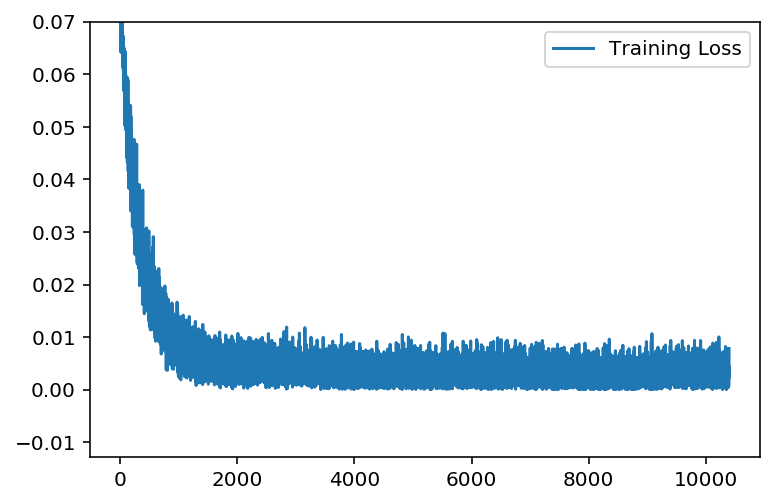

In [36]:
plt.plot(losses, label='Training Loss')
plt.legend()
plt.ylim(ymax=0.07)
plt.show()


with open('runs/256_1_loss_3.csv', 'w') as file_handler:
    for item in losses:
        file_handler.write("{}\n".format(item))

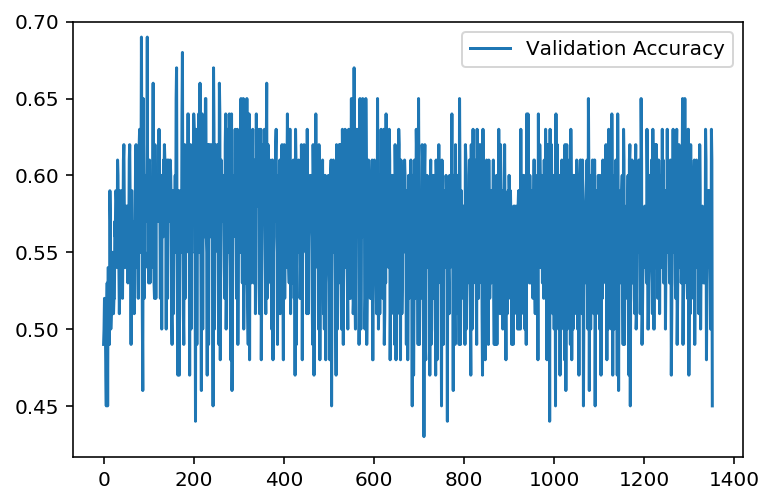

In [37]:
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim(ymax=0.7)
plt.show()

with open('runs/256_1_acc_3.csv', 'w') as file_handler:
    for item in val_acc:
        file_handler.write("{}\n".format(item))

{'boxes': [<matplotlib.lines.Line2D at 0x7f091c10b860>],
 'caps': [<matplotlib.lines.Line2D at 0x7f091c111fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f091c11cdd8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f091c11c400>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f091c10bb00>,
  <matplotlib.lines.Line2D at 0x7f091c111e48>]}

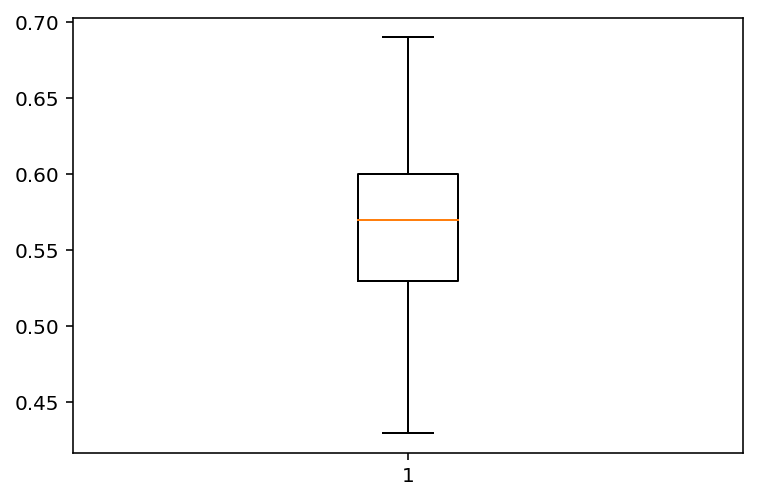

In [38]:
plt.boxplot(val_acc)

### Test RNN on final test set
This code runs final test set to determing final accuracy of trained RNN network. It is important to have a directory where the checkpoint file may be stored for this last testing step.

In [73]:
import random
n_samples = 3
top_n_predictions = 3


test_acc = [] ## Placeholder for test accuracy
preds = [] ## Placeholder for troubleshooting predicitons
correct_preds = [] ## Placeholder for troubleshooting prediction comparisons
correct_args = [] ## Placeholder for troubleshooting boolean argument on predictions
correct_cast = [] ## Place holder for troubleshooting casting boolean into integers
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(X_tst, y_tst, batch_size), 1):
        feed = {inputs_: x,
                labels_: y,
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        # For trouble shooting accuracy calculation errors
        preds.append(sess.run((predictions), feed_dict=feed))
        correct_preds.append(sess.run((correct_pred), feed_dict=feed))
        correct_args.append(sess.run(tf.equal((tf.arg_max(predictions, 1)), (tf.arg_max(y, 1))), feed_dict=feed))
        correct_cast.append(sess.run(tf.cast(correct_pred, tf.float32), feed_dict=feed))
        #print(y)
        test_acc.append(batch_acc)
    print(preds[0])
    #random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(X_tst, y_tst)), n_samples)))
    #print(random_test_features)
    #print(random_test_labels)
    #feed2 = {inputs_: random_test_features, labels_: random_test_labels, keep_prob: 1}
    #random_test_predictions = sess.run(predictions, feed_dict=feed2)
    #print(random_test_predictions)
    #display_image_predictions(random_test_features, random_test_labels, random_test_predictions)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

[array([[  7.79172699e-11,   5.56768573e-16,   2.12373717e-12, ...,
          4.26313851e-13,   8.38768684e-14,   9.85325016e-12],
       [  1.25023762e-05,   3.69962805e-07,   6.27987831e-08, ...,
          8.46562675e-13,   4.62763335e-11,   7.70887464e-14],
       [  4.05519785e-07,   5.03881962e-12,   9.28573607e-11, ...,
          6.45168164e-13,   5.49121187e-13,   1.02152791e-11],
       ..., 
       [  3.63883434e-09,   3.40148567e-08,   6.06710732e-01, ...,
          1.77699078e-10,   3.33407058e-07,   1.95666677e-10],
       [  6.44740453e-07,   1.52846606e-08,   9.99889851e-01, ...,
          7.77958764e-09,   4.97531927e-09,   2.04898868e-07],
       [  9.99998450e-01,   2.19291187e-12,   7.51387175e-10, ...,
          6.03793708e-13,   1.53543549e-11,   1.09172723e-11]], dtype=float32), array([[  2.56912291e-09,   3.33426049e-14,   6.84880930e-10, ...,
          2.01945563e-14,   7.74803399e-12,   3.76108561e-10],
       [  2.06533244e-07,   3.05839992e-10,   1.10181764e-0

In [62]:
def _load_label_names():
    """
    Load the label names from file
    """
    return ['cs', 'astro', 'physics', 'gr', 'hep', 'math', 'nlin', 'nucl', 'cond-mat', 'q-bio', 'q-fin', 'quant-ph', 'stat']

def display_image_predictions(features, labels, predictions):
    n_classes = 13
    label_names = _load_label_names()
    label_binarizer = lb
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [94]:
with tf.Session(graph=graph) as sess:
    print(tf.arg_max(preds[0][1], 0))
    #y_tst[1]
#correct_preds[0]

#display_image_predictions(X_tst[0:2], y_tst[0:2], preds[0][0:2])

Tensor("ArgMax_445:0", shape=(), dtype=int64)


## Conclusions
For a set of 13 subjects, subject prediction accuracies are around 53-57% Accuracies for 9 subjects are around 60%, for 6 subjects around 75%, and for 3 subjects around 90%. Cutting off words with frequencies greater than 600 for this dataset helps. A simple RNN structure peforms the best for this dataset with a single layer containing 64 nodes. The embedding size around 150 also gives consistent optimal performance. To improve accuracy, it is likely we will need to consider the fact that a paper can fall in multiple categories.  